In [ ]:
''' ANALYSIS REPORT (etl_analysis.py)
Read table from Supabase and generate:
📊 Metrics
Churn percentage
Average monthly charges per contract
Count of new, regular, loyal, champion customers
Internet service distribution
Pivot table: Churn vs Tenure Group
Optional visualizations:
Churn rate by Monthly Charge Segment
Histogram of TotalCharges
Bar plot of Contract types
Save output CSV into:
data/processed/analysis_summary.csv'''

In [1]:
# Cell 1 — Setup & imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

BASE_DIR = os.getcwd()   # notebook working dir
OUTPUT_DIR = os.path.join(BASE_DIR, "data", "processed")
PLOTS_DIR = os.path.join(OUTPUT_DIR, "plots")
os.makedirs(PLOTS_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("Outputs will be saved to:", OUTPUT_DIR)


Outputs will be saved to: c:\aids_training_day1\Day13_ETL_Pipeline_Titanic\telco_customer\data\processed


In [2]:
# Cell 2 — Supabase helper (falls back to local CSV if SUPABASE not available)
def get_supabase_client():
    try:
        from supabase import create_client
    except Exception as e:
        # supabase package not installed or import failed
        return None

    url = os.environ.get("SUPABASE_URL")
    key = os.environ.get("SUPABASE_KEY")
    if not url or not key:
        return None
    return create_client(url, key)

def load_table_from_supabase(table_name='telco_customer'):
    client = get_supabase_client()
    if client is None:
        return None
    try:
        resp = client.table(table_name).select("*").execute()
        # support different response shapes
        if isinstance(resp, dict):
            data = resp.get('data')
        else:
            data = getattr(resp, 'data', None)
        if data is None:
            print("Supabase returned no data or unexpected response:", resp)
            return None
        return pd.DataFrame(data)
    except Exception as e:
        print("Error querying Supabase:", e)
        return None

def load_data():
    # Try Supabase first
    df = load_table_from_supabase('telco_customer')
    if df is not None:
        print("Loaded data from Supabase, rows:", len(df))
        return df

    # Fallback paths (common names)
    candidates = [
        os.path.join(BASE_DIR, "data", "staged", "telco_customer_transformed.csv"),
        os.path.join(BASE_DIR, "data", "staged", "telco_customer_transformed.csv".lower()),
        os.path.join(BASE_DIR, "data", "staged", "telco_customer_transformed.csv".replace("telco_","")),
        os.path.join(BASE_DIR, "data", "staged", "telco_customer_transformed.csv")
    ]
    for p in candidates:
        if os.path.exists(p):
            print("Loading fallback CSV:", p)
            return pd.read_csv(p)

    raise FileNotFoundError("Could not load data from Supabase or local staged CSV. Place the staged CSV at data/staged/")


In [3]:
# Cell 3 — Load data and basic conversions
df = load_data()
print("Raw dataframe shape:", df.shape)
display(df.head())

# Convert TotalCharges to numeric (coerce spaces/invalid → NaN)
if 'TotalCharges' in df.columns:
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Ensure numeric columns exist and fill required missing values if needed (this is safe for analysis)
for col in ['tenure', 'MonthlyCharges', 'TotalCharges']:
    if col in df.columns:
        # If there are NaNs, leave them for validation step but convert dtype
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Standardize Churn values (lowercase strings) for later calculations
if 'Churn' in df.columns:
    df['Churn_clean'] = df['Churn'].astype(str).str.strip().str.lower()
else:
    df['Churn_clean'] = np.nan


Loading fallback CSV: c:\aids_training_day1\Day13_ETL_Pipeline_Titanic\telco_customer\data\staged\telco_customer_transformed.csv
Raw dataframe shape: (7043, 24)


,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,...,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,tenure_group,monthly_charge_segment,has_internet_service,is_multi_line_user,contract_type_code
0,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,...,Yes,Electronic check,29.85,1397.475,No,New,Low,1,0,0
1,0,No,No,34,Yes,No,DSL,Yes,No,Yes,...,No,Mailed check,56.95,1397.475,No,Regular,Medium,1,0,1
2,0,No,No,2,Yes,No,DSL,Yes,Yes,No,...,Yes,Mailed check,53.85,1397.475,Yes,New,Medium,1,0,0
3,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,...,No,Bank transfer (automatic),42.30,1397.475,No,Loyal,Medium,1,0,1
4,0,No,No,2,Yes,No,Fiber optic,No,No,No,...,Yes,Electronic check,70.70,1397.475,Yes,New,High,1,0,0


In [4]:
# Cell 4 — helper flags and expected columns checks
# churn_flag: 1 for yes/true/1, else 0 (NaN => 0)
df['churn_flag'] = df['Churn_clean'].map(lambda x: 1 if str(x) in ['yes','1','true'] else 0)

# If monthly_charge_segment missing, create a simple segmentation (optional but useful)
if 'monthly_charge_segment' not in df.columns:
    # Segment by MonthlyCharges quantiles: Low, Medium, High
    if 'MonthlyCharges' in df.columns:
        q1 = df['MonthlyCharges'].quantile(0.33)
        q2 = df['MonthlyCharges'].quantile(0.66)
        def seg(m):
            if pd.isna(m): return "Unknown"
            if m <= q1: return "Low"
            if m <= q2: return "Medium"
            return "High"
        df['monthly_charge_segment'] = df['MonthlyCharges'].apply(seg)
    else:
        df['monthly_charge_segment'] = "Unknown"

# Check for tenure_group column (if missing create from tenure per spec)
if 'tenure_group' not in df.columns and 'tenure' in df.columns:
    def tenure_grp(t):
        try:
            t = float(t)
        except:
            return "Unknown"
        if t <= 12:
            return "New"
        elif 13 <= t <= 36:
            return "Regular"
        elif 37 <= t <= 60:
            return "Loyal"
        elif t > 60:
            return "Champion"
        else:
            return "Unknown"
    df['tenure_group'] = df['tenure'].apply(tenure_grp)

# Brief column presence report
expected = ['tenure','MonthlyCharges','TotalCharges','Churn','InternetService','Contract',
            'PaymentMethod','tenure_group','monthly_charge_segment','has_internet_service',
            'is_multi_line_user','contract_type_code']
missing_cols = [c for c in expected if c not in df.columns]
if missing_cols:
    print("Warning: missing expected columns (some metrics may be partial):", missing_cols)


In [5]:
# Cell 5 — Compute metrics and save analysis_summary.csv
metrics = {}

# 1) Churn percentage
metrics['total_rows'] = len(df)
if len(df) > 0:
    metrics['churn_percentage'] = df['churn_flag'].sum() / len(df) * 100
else:
    metrics['churn_percentage'] = None

# 2) Average monthly charges per contract
if 'Contract' in df.columns and 'MonthlyCharges' in df.columns:
    metrics['avg_monthly_by_contract'] = df.groupby('Contract')['MonthlyCharges'].mean().to_dict()
else:
    metrics['avg_monthly_by_contract'] = {}

# 3) Count of tenure groups (New, Regular, Loyal, Champion)
metrics['tenure_group_counts'] = df['tenure_group'].value_counts(dropna=False).to_dict()

# 4) Internet service distribution
if 'InternetService' in df.columns:
    metrics['internet_service_distribution'] = df['InternetService'].value_counts().to_dict()
else:
    metrics['internet_service_distribution'] = {}

# 5) Pivot table: Churn vs Tenure Group (counts & churn rate)
pivot_counts = None
pivot_rates = None
if 'tenure_group' in df.columns and 'churn_flag' in df.columns:
    pivot_counts = pd.crosstab(df['tenure_group'], df['Churn_clean'])
    pivot_rates = pivot_counts.div(pivot_counts.sum(axis=1), axis=0)

# Prepare flat summary DataFrame for CSV
rows = []
rows.append({'metric':'total_rows','value': metrics['total_rows']})
rows.append({'metric':'churn_percentage','value': metrics['churn_percentage']})
# avg monthly per contract
for k,v in metrics['avg_monthly_by_contract'].items():
    rows.append({'metric':f'avg_monthly_contract_{k}','value': v})
# tenure group counts
for k,v in metrics['tenure_group_counts'].items():
    rows.append({'metric':f'tenure_group_count_{k}','value': v})
# internet distribution
for k,v in metrics['internet_service_distribution'].items():
    rows.append({'metric':f'internet_service_{k}','value': v})

summary_df = pd.DataFrame(rows)
summary_csv_path = os.path.join(OUTPUT_DIR, 'analysis_summary.csv')
summary_df.to_csv(summary_csv_path, index=False)
print("Saved analysis summary to:", summary_csv_path)

# Save pivot CSVs if present
if pivot_counts is not None:
    pivot_counts.to_csv(os.path.join(OUTPUT_DIR, 'pivot_churn_counts_by_tenure_group.csv'))
if pivot_rates is not None:
    pivot_rates.to_csv(os.path.join(OUTPUT_DIR, 'pivot_churn_rates_by_tenure_group.csv'))

# Print summary in notebook
import pprint
print("\nMetrics:")
pprint.pprint(metrics)
if pivot_counts is not None:
    print("\nPivot (counts):")
    display(pivot_counts)
if pivot_rates is not None:
    print("\nPivot (rates):")
    display(pivot_rates)


Saved analysis summary to: c:\aids_training_day1\Day13_ETL_Pipeline_Titanic\telco_customer\data\processed\analysis_summary.csv

Metrics:
{'avg_monthly_by_contract': {'Month-to-month': 66.39849032258064,
                             'One year': 65.04860828241684,
                             'Two year': 60.770412979351036},
 'churn_percentage': np.float64(26.536987079369588),
 'internet_service_distribution': {'DSL': 2421,
                                   'Fiber optic': 3096,
                                   'No': 1526},
 'tenure_group_counts': {'Champion': 1407,
                         'Loyal': 1644,
                         'New': 2186,
                         'Regular': 1806},
 'total_rows': 7043}

Pivot (counts):


Churn_clean,no,yes
tenure_group,,
Champion,1314,93
Loyal,1369,275
New,1149,1037
Regular,1342,464



Pivot (rates):


Churn_clean,no,yes
tenure_group,,
Champion,0.933902,0.066098
Loyal,0.832725,0.167275
New,0.525618,0.474382
Regular,0.743079,0.256921


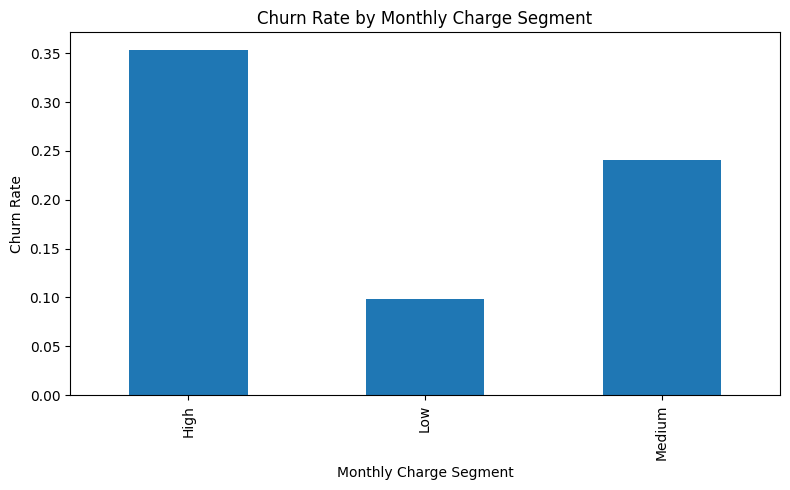

Saved plot: c:\aids_training_day1\Day13_ETL_Pipeline_Titanic\telco_customer\data\processed\plots\churn_rate_by_monthly_charge_segment.png


In [6]:
# Cell 6 — Plot churn rate by monthly_charge_segment
if 'monthly_charge_segment' in df.columns and 'churn_flag' in df.columns:
    seg_df = df[['monthly_charge_segment','churn_flag']].copy()
    churn_by_seg = seg_df.groupby('monthly_charge_segment')['churn_flag'].mean().sort_index()
    plt.figure(figsize=(8,5))
    churn_by_seg.plot(kind='bar')   # do not set colors explicitly (per notebook guidelines)
    plt.title('Churn Rate by Monthly Charge Segment')
    plt.ylabel('Churn Rate')
    plt.xlabel('Monthly Charge Segment')
    plt.tight_layout()
    path = os.path.join(PLOTS_DIR, 'churn_rate_by_monthly_charge_segment.png')
    plt.savefig(path)
    plt.show()
    print("Saved plot:", path)
else:
    print("Skipping churn-by-segment plot: required columns missing.")


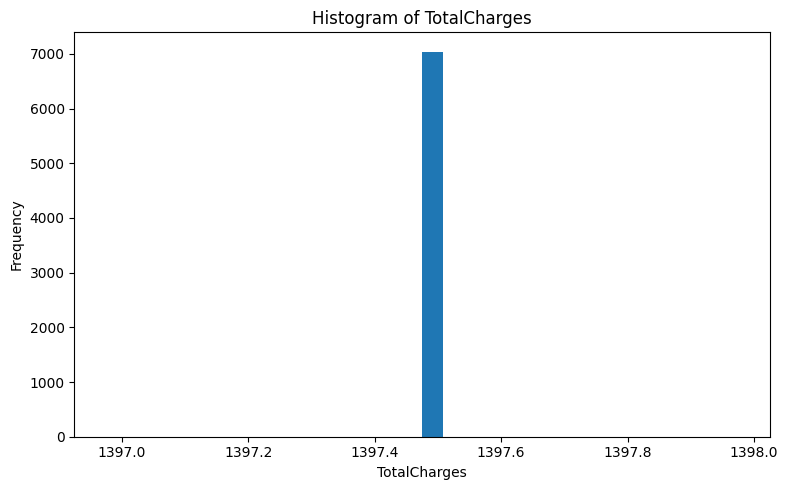

Saved plot: c:\aids_training_day1\Day13_ETL_Pipeline_Titanic\telco_customer\data\processed\plots\hist_totalcharges.png


In [7]:
# Cell 7 — Histogram of TotalCharges
if 'TotalCharges' in df.columns:
    plt.figure(figsize=(8,5))
    non_na = df['TotalCharges'].dropna()
    if len(non_na) > 0:
        plt.hist(non_na, bins=30)
        plt.title('Histogram of TotalCharges')
        plt.xlabel('TotalCharges')
        plt.ylabel('Frequency')
        plt.tight_layout()
        path = os.path.join(PLOTS_DIR, 'hist_totalcharges.png')
        plt.savefig(path)
        plt.show()
        print("Saved plot:", path)
    else:
        print("No TotalCharges data to plot.")
else:
    print("Skipping TotalCharges histogram: column missing.")


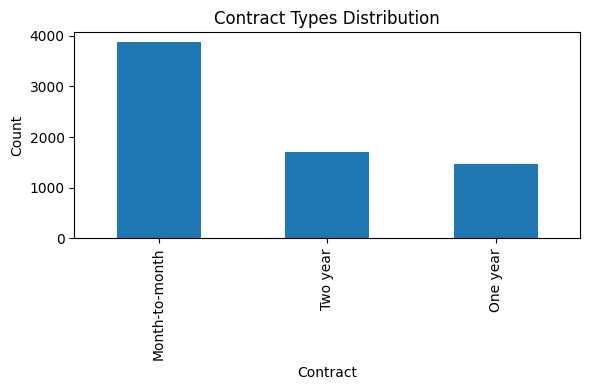

Saved plot: c:\aids_training_day1\Day13_ETL_Pipeline_Titanic\telco_customer\data\processed\plots\contract_types.png


In [8]:
# Cell 8 — Bar plot of Contract types
if 'Contract' in df.columns:
    counts = df['Contract'].value_counts()
    plt.figure(figsize=(6,4))
    counts.plot(kind='bar')
    plt.title('Contract Types Distribution')
    plt.xlabel('Contract')
    plt.ylabel('Count')
    plt.tight_layout()
    path = os.path.join(PLOTS_DIR, 'contract_types.png')
    plt.savefig(path)
    plt.show()
    print("Saved plot:", path)
else:
    print("Skipping contract types plot: column missing.")


In [9]:
# Cell 9 — Final wrap-up
print("Done.\nFiles created:")
print(" - analysis summary:", summary_csv_path)
print(" - pivots (if any):", os.path.join(OUTPUT_DIR, 'pivot_churn_counts_by_tenure_group.csv'))
print(" - plots folder:", PLOTS_DIR)


Done.
Files created:
 - analysis summary: c:\aids_training_day1\Day13_ETL_Pipeline_Titanic\telco_customer\data\processed\analysis_summary.csv
 - pivots (if any): c:\aids_training_day1\Day13_ETL_Pipeline_Titanic\telco_customer\data\processed\pivot_churn_counts_by_tenure_group.csv
 - plots folder: c:\aids_training_day1\Day13_ETL_Pipeline_Titanic\telco_customer\data\processed\plots
